In [1]:
##### base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os

# matplotlib
%matplotlib inline

# display
from IPython.display import display

# autoreload
%load_ext autoreload
%autoreload 2

# warnings
import warnings
warnings.filterwarnings('ignore')

# fix random seed
from numpy.random import seed as set_random_seed
set_random_seed(42)

# explainability
# import shap, lime #eli5
# shap.initjs()

# debug
# from icecream import ic
# debug = ic
import logging
logg = logging.info

In [2]:
import os, sys, re
import argparse
import time
import random
import logging

from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from torch._C import device
from torch.utils.data import DataLoader
import torch

from modules.train import train
from modules.test import test
from modules.loader import CustomBamDataset2
import utils.utils as util
from utils.utils import Parms

In [3]:
parser = argparse.ArgumentParser('Train or test SomaticSerum model.')
parser.add_argument('training_bam_dir', type=str,
                    help='Train data bams directory')
parser.add_argument('--sample_split', required=False, type=str,
                    help='How to split the training data: True - by samples, False - by random on the entire dataset',
                    default = 'True')
parser.add_argument('--model', required=False, type=str, 
                    help='model', default='SimpleCnn')
parser.add_argument('--hidden_size', required=False, type=int,
                    help='The number of hidden units', default=64)
parser.add_argument('--sequence_length', required=False, type=int,
                    help='The length of the sequence', default=200)
parser.add_argument('--batch_size', required=False, type=int,
                    help='The size of each batch', default=512)
parser.add_argument('--learning_rate', required=False, type=float,
                    help='The learning rate value', default=0.00001)
parser.add_argument('--max_epoch', required=False, type=int,
                    help='The maximum epoch', default=100)
parser.add_argument('--lstm_layers', required=False, type=int,
                    help='Num of LSTM layers', default=10)
parser.add_argument('--dropout', required=False, type=float,
                    help='Dropout', default=0.5)
parser.add_argument('--num_workers', required=False, type=int,
                    help='Number of workers', default=1)
parser.add_argument('--out', required=False, type=str,
                    help='Output directory', default='output')
parser.add_argument('--test', required=False, type=str,
                    help='Test directory')
# args = parser.parse_args()

args = parser.parse_known_args()[0]
args.__dict__.update(dict(
#         training_bam_dir="../data/seqmerge/DLbams_rand",
#         training_bam_dir='/data/alonwolf/projects/SomaticSerum/data/seqmerge/DLbams_rand',
        training_bam_dir='/data/alonwolf/projects/SomaticSerum/data/sample',
#         training_bam_dir='/data/alonwolf/projects/SomaticSerum/data/seqmerge/DLbams',
        sample_split=True,
        model="metaSimpleDense",
        hidden_size=64,
        batch_size=32,
        learning_rate=0.001,
        max_epoch=20,
        dropout=0.005,
#         out=MassiveLoop3,
    ))
parms = Parms(
    args
)

root        : INFO     Logger initialized


In [4]:
from modules.loader import CustomBamDataset2
full_train_dataset  = CustomBamDataset2(parms.BAM_DIR, out = parms.OUT, whichSet = 'train', force = True)
train_size          = int(parms.TRAIN_VALIDATION_SPLIT * len(full_train_dataset))
val_size            = len(full_train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

root        : INFO     Dataloading train
root        : INFO     Longest read: 683
root        : INFO     Loading reads from: somatic_reads.LUAD02.SNVs.srt.bam 		bam file number 0
root        : INFO     Loading reads from: normal_reads.LUAD02.SNVs.srt.bam 		bam file number 1
root        : INFO     Number of Normal reads: 2389, Number of Somatic reads: 2621. Ratio: 0.911


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size = parms.BATCH_SIZE, shuffle = True, num_workers = parms.NUM_WORKERS)
valid_dataloader = DataLoader(valid_dataset, batch_size = parms.BATCH_SIZE, shuffle = True, num_workers = parms.NUM_WORKERS)

In [6]:
def torch_ds_to_numpy(ds):
    sample_dataloader = DataLoader(ds, batch_size = len(ds), shuffle = True, num_workers = 1)
    for batch in sample_dataloader:
        break
    return [df.numpy() for df in batch]

x_dna, x_att, y = torch_ds_to_numpy(train_dataset)
x_dna.shape, x_att.shape, y.shape

((4008, 3, 200), (4008, 12), (4008,))

In [7]:
# # --- Model setup ----------------------------------------------------
# logging.info('Setting up the model...')
# nucleotide_model    = parms.return_model(meta_dim = x_att.shape[1])
# loss_fn             = torch.nn.CrossEntropyLoss()
# model_params        = list(nucleotide_model.parameters())
# optimizer           = torch.optim.AdamW(model_params, lr=parms.LEARNING_RATE, eps=1e-08, weight_decay=0.01)


# # --- Training -------------------------------------------------------
# logging.info('Setting up the model...')
# if torch.cuda.is_available():
#     nucleotide_model = nucleotide_model.cuda()
#     device = 'cuda'
# else:
#     device = 'cpu'
# logg(device)

# if parms.TEST:
#     # Skip training
#     logging.info('Skipping train')
#     metric = pd.read_csv('{}/metric.csv'.format(parms.TEST))
#     name = '{}/{}'.format(parms.TEST, [f for f in os.listdir(parms.TEST) if f.endswith('.txt')][0].split('txt')[0])
#     model_path = "{}/{}.pth".format(parms.TEST, type(nucleotide_model).__name__)
#     metric_test = test(parms, model_path, test_dataloader, device, loss_fn)
# else:
#     logging.info('Training...')
#     history, name, metric, model_path = train(model = nucleotide_model,
#                                 optimizer = optimizer,
#                                 loss_fn = loss_fn,
#                                 train_dl = train_dataloader,
#                                 val_dl = valid_dataloader,
#                                 epochs = parms.MAX_EPOCH,
#                                 device = device,
#                                 out = parms.OUT)
#     # Test
#     metric_test = test(parms, model_path, valid_dataloader, device, loss_fn)

# # --- Plotting -------------------------------------------------------
# logging.info('Plotting...')
# util.plot(name, metric, metric_test, parms.OUT)

# acc = history['acc']
# val_acc = history['val_acc']
# loss = history['loss']
# val_loss = history['val_loss']
# epochs = range(1, len(acc) + 1)

# logging.info("Done!")

In [8]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

NameError: name 'history' is not defined

In [ ]:
plt.plot(epochs, val_acc)
plt.plot(epochs, acc)

In [ ]:
nucleotide_model.forward(torch.Tensor(x_dna[[5],:]), torch.Tensor(x_att[[5],:]))[0][0].detach().numpy()

In [9]:
len(train_dataset)

4008

In [10]:
np.histogram(x[y==0])

NameError: name 'x' is not defined

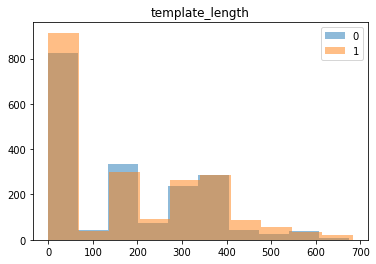

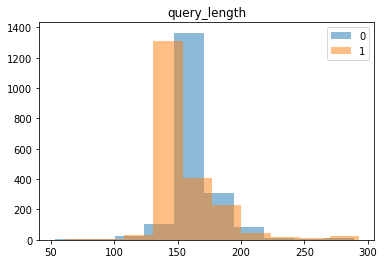

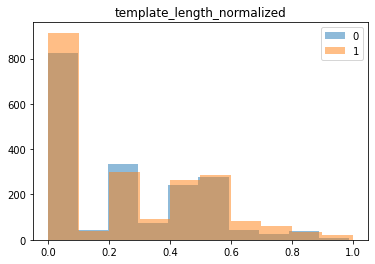

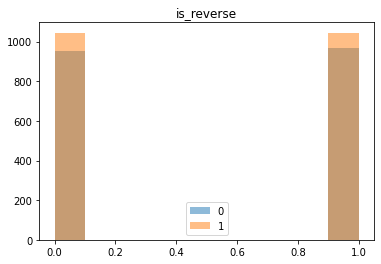

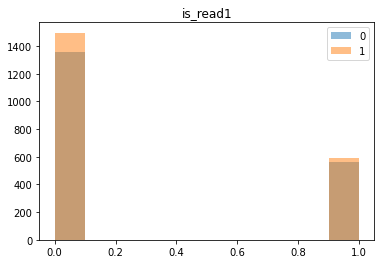

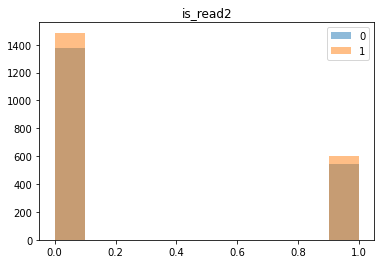

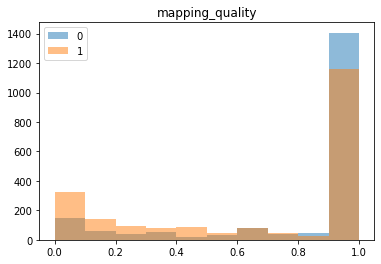

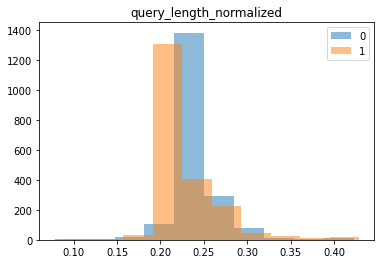

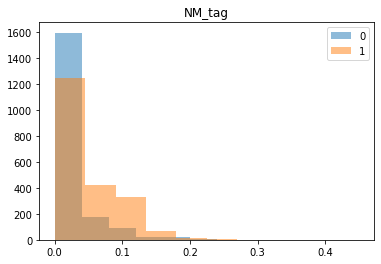

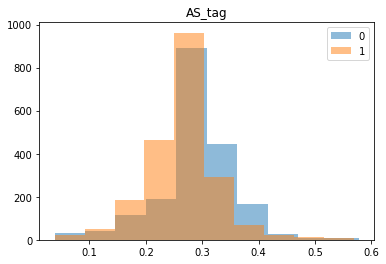

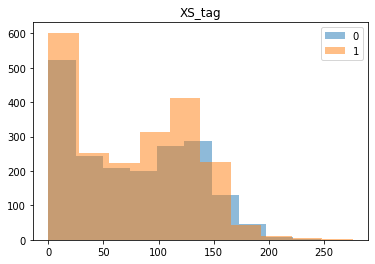

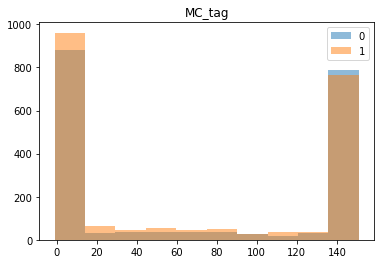

In [11]:
def print_feature(x,y,title = None):
    if title: plt.title(title) 
    for label in [0,1]:
        plt.hist(x[y==label], alpha = 0.5, label = label)
    plt.legend()
    plt.show()

def save_feature_histogram(x,y, title):
    hist_0, bin_edges_0 = np.histogram(x[y==0])
    hist_1, bin_edges_1 = np.histogram(x[y==1])
    pd.DataFrame({
        'bins_healthy': bin_edges_0[1:],
        'hist_healthy': hist_0,
        'bins_somatic': bin_edges_1[1:],
        'hist_somatic': hist_1
    }
    ).to_excel(PLOTS_DIR / f"histogram__{title}.xlsx")
    
titles = [
    'template_length',
    'query_length',
    'template_length_normalized',
    'is_reverse',
    'is_read1',
    'is_read2',
    'mapping_quality',
    'query_length_normalized',
    'NM_tag',
    'AS_tag',
    'XS_tag',
    'MC_tag'
]
for i in range(x_att.shape[1]):
    print_feature(x_att[:,i], y, title=titles[i])

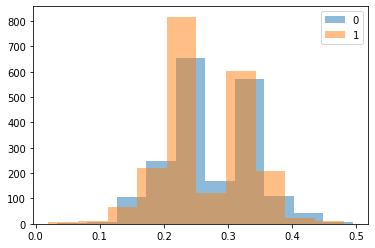

In [12]:
feat = x_dna[:,1]
feat[feat<0] = 0
feat = feat.mean(axis = 1)
print_feature(feat, y)

(array([1921.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2087.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

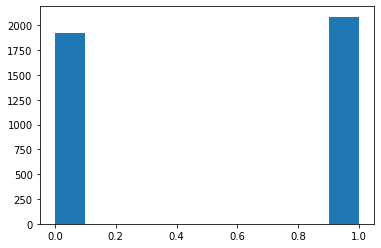

In [13]:
plt.hist(y)

In [14]:
x_dna[:,1]

array([[0.387, 0.366, 0.409, ..., 0.   , 0.   , 0.   ],
       [0.323, 0.29 , 0.301, ..., 0.   , 0.   , 0.   ],
       [0.312, 0.323, 0.301, ..., 0.323, 0.323, 0.323],
       ...,
       [0.323, 0.29 , 0.323, ..., 0.   , 0.   , 0.   ],
       [0.323, 0.194, 0.226, ..., 0.   , 0.   , 0.   ],
       [0.323, 0.269, 0.323, ..., 0.   , 0.   , 0.   ]], dtype=float32)

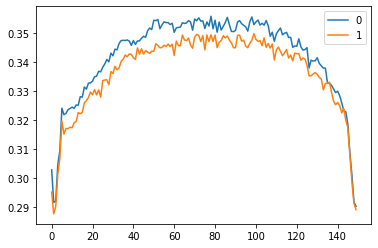

In [15]:
quals = x_dna[:,1]
quals[quals<0] = 0
plt.plot(quals[y == 0].mean(axis = 0)[:150], label = 0)
plt.plot(quals[y == 1].mean(axis = 0)[:150],label = 1)
plt.xlabel('')

plt.legend()
plt.show()


In [16]:
# pd.DataFrame({
#     'bp': np.arange(150),
#     'somatic': quals[y == 1].mean(axis = 0)[:150],
#     'healthy': quals[y == 0].mean(axis = 0)[:150]
# }).to_excel(PLOTS_DIR / 'quality_comparison_LUAD02.xlsx')

In [20]:
# quals = x_dna[:,1]#.mean(axis=1)
# x = np.hstack([x_att, quals.mean(axis=1).reshape(-1,1)])

x = x_dna
x.shape

(4008, 3, 200)

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [26]:
from models import *
# clf = LogisticModel(max_iter = 1000, C=0.8)

# clf = LGBMModel(n_estimators=10, max_depth=5, colsample_bytree=0.2)

# clf = XGBModel(n_estimators=30, max_depth=5, colsample_bytree=0.8)

# clf = SkorchModel(n_features)

# clf = KerasModel()

In [70]:
from models.torch import TorchModel

[autoreload of models.torch failed: Traceback (most recent call last):
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensi

In [89]:
from modules.models import metaSimpleDense, nucSimpleCnn, nucCnnLinear

In [90]:
from models.torch import TorchModel
from modules.models import metaSimpleDense

clf = TorchModel(nucSimpleCnn())#input_size=200, hidden_size=50, linear_size=10))

In [91]:
from sklearn.metrics import f1_score, accuracy_score
from utils.metric_utils import HardMetric
final_metric = HardMetric(f1_score)

In [92]:
# from models import *

# x_train = pd.DataFrame(x_train)
# y_train = pd.Series(y_train)

# from models.optuna import OptunaCV
# clf = OptunaCV.optimize(
#     x_train,
#     y_train,
#     estimators= [XGBModel, LGBMModel, KerasModel],
#     metric=final_metric,
#     n_trials = 100
# )

In [93]:
# from models.skorch import SkorchModel
# from modules.models import SimpleCnn, nucSimpleCnnOrig, metaSimpleDense
# clf = SkorchModel(metaSimpleDense(input_size=x_train.shape[1], hidden_size = 5), optimizer__lr=0.005)

[autoreload of models.torch failed: Traceback (most recent call last):
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/data/alonwolf/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/extensi

In [94]:
# from sklearn.svm import SVC
# # clf = SVC(probability=True)

# from xgboost import XGBClassifier
# clf = XGBClassifier()

In [99]:
# x_train = pd.DataFrame(x_train)
# y_train = pd.Series(y_train)

clf.fit(x_train, y_train, learning_rate=0.001, epochs=30)

root        : INFO     Epoch   1/ 30, train loss: 0.0218, train acc: 0.5017
root        : INFO     Epoch   2/ 30, train loss: 0.0218, train acc: 0.5083
root        : INFO     Epoch   3/ 30, train loss: 0.0217, train acc: 0.5040
root        : INFO     Epoch   4/ 30, train loss: 0.0217, train acc: 0.5250
root        : INFO     Epoch   5/ 30, train loss: 0.0218, train acc: 0.5050
root        : INFO     Epoch   6/ 30, train loss: 0.0217, train acc: 0.5210
root        : INFO     Epoch   7/ 30, train loss: 0.0217, train acc: 0.5060
root        : INFO     Epoch   8/ 30, train loss: 0.0216, train acc: 0.5243
root        : INFO     Epoch   9/ 30, train loss: 0.0216, train acc: 0.5236
root        : INFO     Epoch  10/ 30, train loss: 0.0217, train acc: 0.4980
root        : INFO     Epoch  11/ 30, train loss: 0.0216, train acc: 0.5256
root        : INFO     Epoch  12/ 30, train loss: 0.0216, train acc: 0.5336
root        : INFO     Epoch  13/ 30, train loss: 0.0215, train acc: 0.5333
root        

In [100]:
y_pred = clf.predict_proba(x_test)[:,1]

In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
for th in np.arange(20)/20:
    print(f'''at {th} acc is {np.round(accuracy_score(y_test, (y_pred > th)),2)} prec is {np.round(precision_score(y_test, (y_pred > th)),2)} rec is {np.round(recall_score(y_test, (y_pred > th)),2)} f1_score is {np.round(f1_score(y_test, (y_pred > th)),2)}''')

at 0.0 acc is 0.54 prec is 0.54 rec is 1.0 f1_score is 0.7
at 0.05 acc is 0.53 prec is 0.54 rec is 0.93 f1_score is 0.68
at 0.1 acc is 0.53 prec is 0.54 rec is 0.89 f1_score is 0.67
at 0.15 acc is 0.53 prec is 0.54 rec is 0.86 f1_score is 0.67
at 0.2 acc is 0.53 prec is 0.54 rec is 0.83 f1_score is 0.66
at 0.25 acc is 0.53 prec is 0.55 rec is 0.8 f1_score is 0.65
at 0.3 acc is 0.52 prec is 0.54 rec is 0.76 f1_score is 0.63
at 0.35 acc is 0.51 prec is 0.54 rec is 0.7 f1_score is 0.61
at 0.4 acc is 0.51 prec is 0.55 rec is 0.64 f1_score is 0.59
at 0.45 acc is 0.52 prec is 0.56 rec is 0.55 f1_score is 0.55
at 0.5 acc is 0.52 prec is 0.57 rec is 0.43 f1_score is 0.49
at 0.55 acc is 0.5 prec is 0.57 rec is 0.33 f1_score is 0.42
at 0.6 acc is 0.49 prec is 0.57 rec is 0.26 f1_score is 0.36
at 0.65 acc is 0.5 prec is 0.58 rec is 0.24 f1_score is 0.34
at 0.7 acc is 0.49 prec is 0.59 rec is 0.21 f1_score is 0.31
at 0.75 acc is 0.49 prec is 0.61 rec is 0.18 f1_score is 0.28
at 0.8 acc is 0.49 pre

In [114]:
from config import PLOTS_DIR

from sklearn.metrics import precision_recall_curve, roc_curve
def save_curve_to_xlsx(f_curve, y_test, y_pred, x_name='x', y_name='y'):
    f_curve = roc_curve
    x, y, thresholds = f_curve(y_test, y_pred)
    if len(thresholds) < len(y):
        thresholds = np.pad(thresholds, pad_width=(1,0))
    pd.DataFrame({
        x_name: x,
        y_name: y,
        'thresholds': thresholds
    }).to_excel(PLOTS_DIR / f'{f_curve.__name__}_{str(clf).split("(")[0]}.xlsx')
# save_curve_to_xlsx(precision_recall_curve,y_test, y_pred,'prec','recall')
# save_curve_to_xlsx(roc_curve,y_test, y_pred,'fpr', 'tpr')

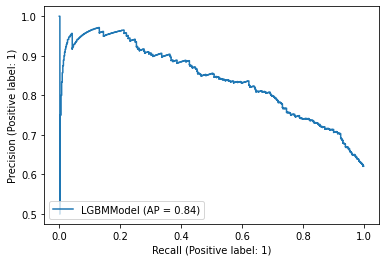

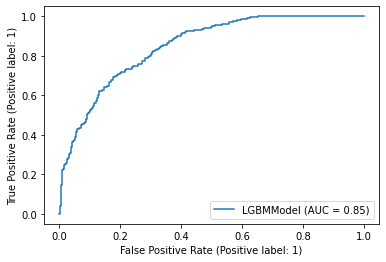

In [109]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
plot_precision_recall_curve(clf, pd.DataFrame(x_test), y_test)
plot_roc_curve(clf, pd.DataFrame(x_test), y_test)

In [ ]:
print_feature(x_att[:,-2], y)

In [ ]:
clf.feature_importances_